# ***Análisis de correspondencias simples.***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***
## ***Docente: Luis Andrés Campos Maldonado.***

Vamos a hacer uso de la librería [prince](https://pypi.org/project/prince/). Pero tomaremos la referencia de las últimas actualizaciones que están en el siguiente [repositorio](https://github.com/MaxHalford/prince). 

## ***Protocolo de librerias y funciones auxiliares.***

In [1]:
%%capture
!pip install git+https://github.com/MaxHalford/Prince

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import plotly.express as px
import warnings
from scipy.stats import chi2_contingency
##
plt.style.use("ggplot")
#sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (15,6)
warnings.filterwarnings("ignore")

In [3]:
def improve_text_position(x):
  """"
      Esta función intercala las etiquetas en el texto de un plot en plotly
  """
  positions = ["top center", "bottom center"]
  return [positions[i % len(positions)] for i in range(len(x))]

In [4]:
def get_eigenvalue(ca):
  """
      Esta función muestra la inercia para cada una de las componetes.
      Input: -----> ca: Objecto CA de la libreria prince.
      Output: ----> pd.DataFrame con los eigenvalues, varianza y varianza acumulada de cada dimensión.
  """
  
  eigen, var, = np.around(ca.eigenvalues_, decimals = 3), np.array(ca.explained_inertia_)
  n_compo, var = ca.n_components, np.around(var, decimals = 3)
  indexs = [f"Dim{i+1}" for i in range(0,n_compo)]
  result = pd.DataFrame({"eigenvalue":eigen,"variance_percent":var*100,
                         "cumulative_variance_percent":np.cumsum(var)*100},index = indexs)
  return result

In [5]:
def get_cos2(ca, df_ca, choice="index"):
  """
      Función que encuentran la cantidad de representación de las filas (columnas) en el 
      correspondiente factor.

      * Input: ----> ca: Objeto CA de la librería prince.
               ----> df_ca : pd.DataFrame con quien se ajustó el CA del parámetro ca, DEBE
                            ser la tabla de contingencias.
               ----> choice (str): choice de los cos2 solicitados. Puede ser "index" o "columns"
                                   Default = "index"
      * Output: ---> pd.DataFrame con los cos2.  
  """
  name_index, name_column = df_ca.index.name, df_ca.columns.name
  col_masse, row_masse, n_dim = ca.col_masses_.values, ca.row_masses_.values, ca.n_components
  columns_name = [f'Dim{i+1}' for i in range(0,n_dim)]
  b, c = ((ca.F)**2).values, ((ca.G)**2).values
  ###
  if choice == "index":
    crosstab = df_ca.values/df_ca.sum(axis = 1).values.reshape(-1,1)
    a = ((crosstab - col_masse)**2/col_masse).sum(axis=1)
    a = a.reshape(len(crosstab),1)
    result = b/a
    result = pd.DataFrame(result, index = df_ca.index.values,columns = columns_name).round(3)
  ###   
  elif choice == "columns":
    df_ca = df_ca.T
    crosstab = df_ca.values/df_ca.sum(axis = 1).values.reshape(-1,1)
    a = ((crosstab - row_masse)**2/row_masse).sum(axis=1)
    a = a.reshape(len(crosstab),1)
    result = c/a
    result = pd.DataFrame(result, index = df_ca.index.values,columns = columns_name).round(3)
  
  return result

In [6]:
def screeplot(ca, figsize=(15,6)):
  """
      Esta función genera el gráfico de sedimentación del análisis de correspondencias.
      Input: ----> ca: Objeto CA de la libreria prince.
             ----> figsize: Tupla (x,y); x: ancho del plot, y: alto del plot.
      Output: ---> None.
  """
  inertia = ca.explained_inertia_ 
  line, barras, n_compo = np.mean(inertia)*100, np.array(inertia)*100, len(inertia)
  plt.figure(figsize=figsize)
  plt.bar([str(i+1) for i in range(0,n_compo)],barras, color = "blue")
  plt.xlabel("Dimensions")
  plt.ylabel("Percentage of explained variance")
  plt.axhline(y=line, color = "red", linestyle = "--")
  plt.plot([str(i+1) for i in range(0,n_compo)], barras, color = "black", marker = "o")
  plt.title("Scree plot.", fontsize = 20, loc="left")
  plt.show()

  return None

In [7]:
def ca_biplot(ca,df_ca):
  """
      Esta función genera el biplot de un objeto CA de la librería prince.
      Input ----> ca: Objeto CA de la libreria prince.
            ----> df_ca: pd.DataFrame con quien se realizó el ajuste del objeto CA de la libreria prince.
      Output ---> None
  """
  row, col = ca.F, ca.G
  var_exp = np.round(np.array(ca.explained_inertia_)*100,2)
  row["variable"], col["variable"] = df_ca.index.name, df_ca.columns.name
  data_plot = pd.concat([row,col])
  minx, miny = min(data_plot[0]) - 0.2, min(data_plot[1])- 0.2, 
  maxx, maxy = max(data_plot[0]) + 0.2, max(data_plot[1]) + 0.2 
  fig = px.scatter(data_plot, x = 0, y = 1, color = "variable", text = data_plot.index, 
                   symbol="variable", template = "plotly_white", title = "CA-Biplot")
  fig.add_hline(y = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(data_plot[0]))
  fig.update_xaxes(range = [minx, maxx], title_text = f"Dim1 ({var_exp[0]}%)")
  fig.update_yaxes(range = [miny, maxy], title_text = f"Dim2 ({var_exp[1]}%)")
  fig.show()
  
  return None

In [8]:
def plot_bar_cos2(ca, df_ca, choice = "index",width = 700, height=400):
  """
      Esta función genera el plot de los valores de cos2 para las primeras 2 componentes.
      Input:  ----> ca: Objeto CA de la librería prince.
              ----> df_ca: pd.DataFrame con quien se realizó el ajuste del objeto CA de la libreria prince.
              ----> choice (str): Selección de filas ("index") o columnas ("columns) a plotear. 
                    Default "index".
              ----> width (int): Ancho del plot.
              ----> heigth (int): Altura del plot.
      Output: ----> None
  """
  if choice == "index":
    tmp = get_cos2(ca,df_ca,choice = choice)[["Dim1","Dim2"]].sum(axis = 1).sort_values(ascending = False)
    choice = "row"
  elif choice == "columns":
    tmp = get_cos2(ca,df_ca,choice = choice)[["Dim1","Dim2"]].sum(axis = 1).sort_values(ascending = False)
  ## Plot
  fig = px.bar(x = tmp.index, y = tmp.values, template = "plotly_white")
  fig.update_xaxes(title_text = " " )
  fig.update_yaxes(title_text = "Cos2 - Quality of representation")
  fig.update_layout(width = width, height = height,title = f'Cos2 of {choice} to Dim-1-2')  
  fig.show()

  return None

In [9]:
def plot_cos2(ca,df_ca,choice = "index"):
  ##
  var_exp = np.round(np.array(ca.explained_inertia_)*100,2)
  if choice == "index":
    tmp = ca.F
    tmp["cos2"] = get_cos2(ca,df_ca,choice=choice)[["Dim1","Dim2"]].sum(axis = 1)
  elif choice == "columns":
    tmp = ca.G
    tmp["cos2"] = get_cos2(ca,df_ca,choice=choice)[["Dim1","Dim2"]].sum(axis = 1)
  ### Plot.
  fig = px.scatter(data_frame = tmp, x = 0, y = 1, text = tmp.index, color = "cos2",
                    color_continuous_scale="temps", template = "plotly_white")
  if choice == "index":
    fig.update_layout(title = "Row points - CA", )
  elif choice == "columns":
    fig.update_layout(title = "Column points - CA", )
  fig.add_hline(y = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.add_vline(x = 0,line_width=0.5,line_dash="dash",line_color = "black")
  fig.update_traces(textposition=improve_text_position(tmp[0]))
  fig.update_xaxes(range = [min(tmp[0])- 0.2, max(tmp[0]) + 0.2], title_text = f"Dim1 ({var_exp[0]}%)")
  fig.update_yaxes(range = [min(tmp[1])- 0.2, max(tmp[1]) + 0.2], title_text = f"Dim2 ({var_exp[1]}%)")
  fig.show()

  return None

In [10]:
def plot_contrib(ca,df_ca, choice = "index", axes = 1, top = 2):
  """
      Esta función plotea la contribución de cada perfil (fila/columna) en los ejes.
  """
  if choice == "index":
    contrib = ca.row_contributions().rename(columns={0:"Dim1",1:"Dim2",2:"Dim3"})*100
    exp_value, choice = 100/len(df_ca.index), "row"
  elif choice == "columns":
    contrib = ca.column_contributions().rename(columns={0:"Dim1",1:"Dim2",2:"Dim3"})*100
    exp_value = 100/len(df_ca.T.index)
  fig, axes = plt.subplots(1,2, constrained_layout=True, sharey=True)
  tmp1 = contrib.sort_values(by=["Dim1"], ascending = False)
  tmp2 = contrib.sort_values(by=["Dim2"], ascending = False)
  ###
  ax1 = sns.barplot(x = tmp1.index, y =tmp1["Dim1"], ax = axes[0], color = "blue")
  ax1.set_xticklabels(labels = tmp1.index,rotation=-45)
  ax1.axhline(y = exp_value,color='black',ls='--', c = "red")
  ax1.set_ylabel("Contributions (%)", fontsize=15, fontstyle = "italic")
  ax1.set_title(f"Contribution of {choice} to Dim-1", fontsize=20, fontstyle = "italic")
  ###
  ax2 = sns.barplot(x = tmp2.index, y =tmp2["Dim2"], ax = axes[1], color = "blue")
  ax2.set_xticklabels(labels = tmp2.index,rotation=-45)
  ax2.axhline(y = exp_value,color='black',ls='--', c = "red")
  ax2.set_ylabel("Contributions (%)", fontsize=15, fontstyle = "italic")
  ax2.set_title(f"Contribution of {choice} to Dim-2", fontsize=20, fontstyle = "italic")
  plt.show()
  
  return None

In [11]:
## Código para el ejemplo 1.
data = np.array([688,116,584,188,4,326,38,241,110,3, 343,84,909,412,26,98,48,403,681,85,]).reshape(4,5)
data_fi = 100*data/np.sum(data)
columns = ["Rubio(ru)", "Rojo(r)", "Medio(m)","Oscuro(o)", "Negro(n)"]
index = ["Claros(C)","Azules(A)", "Medio(M)","Oscuros(O)"]
example_df = pd.DataFrame(data, columns = columns, index = index)
example_df["Total_(fi.)"] = example_df.apply(np.sum,axis=1)
example_df.loc["Total_(f.j)"] = example_df.apply(np.sum,axis=0)
example_df.columns.rename('Color Cabello', inplace=True)
example_df.index.rename('Color Ojos', inplace=True)
##############
example_dfi = pd.DataFrame(data_fi,columns = ["Rubio(ru)", "Rojo(r)", "Medio(m)","Oscuro(o)", "Negro(n)"],
                          index = ["Claros(C)","Azules(A)", "Medio(M)","Oscuros(O)"])
example_dfi["Total_(fi.)"] = example_dfi.apply(np.sum,axis=1)
example_dfi.loc["Total_(f.j)"] = example_dfi.apply(np.sum,axis=0)
example_dfi.loc["Total_(f.j)","Total_(fi.)"] = 100
## Perfil fila.
pf_row = example_df.copy()
for column in pf_row.columns:
  pf_row[column] = pf_row[column]/pf_row["Total_(fi.)"]
## Perfil columna.
pf_col = example_df.T.copy()
for column in pf_col.columns:
  pf_col[column] = pf_col[column]/pf_col["Total_(f.j)"]

## ***Introducción***

Es común encontrar casos cuyas matrices de datos tienen filas y columnas asociadas con modalidades de variables categóricas. Las entradas de esta matriz contienen la frecuencia absoluta o relativa de los individuos que toman tales valores en cada una de las respectivas modalidades. A estas matrices se le conoce también con el nombre de ***tablas de contingencia***. Un análisis de la información contenida en las filas o en las columnas se hace a través del ***análisis de correspondencias***. Esta técnica puede ser vista como el procedimiento que encuentra la “mejor” representación para dos conjuntos de datos, los dispuestos en filas, o en las columnas de la respectiva matriz de datos. De otra manera, el análisis de correspondencias, tal como el ***PCA***, busca obtener una tipología de las filas o una tipología de las columnas y relacionarlas entre sí. Lo anterior justifica el uso del término correspondencia, pues la técnica busca las filas (o columnas) que se correspondan en información; es decir, que algunas filas (o columnas) pueden estar suministrando información equivalente respecto a un conjunto de individuos. Una de las tareas es encontrar tales filas (o columnas) e interpretar la información allí consignada. En resumen, en lugar de comparar filas/columnas utilizando probabilidades condicionales, el análisis de correspondencias procede a obtener un pequeño número de dimensiones (factores), de tal forma que la primera dimensión explique la mayor parte de la asociación total entre filas y columnas (medidas mediante un coeficiente ji-cuadrado), la segunda dimensión explique la mayor parte del residuo de la asociación no explicada por la primera, y así sucesivamente con el resto de las dimensiones.



El número máximo de dimensiones es igual al ***menor número de categorías de cualquiera de las dos variables (fila o columna), menos uno, pero comúnmente dos o tres dimensiones*** son suficientes para representar con rigor la asociación entre las dos variables. En este sentido
las dimensiones son conceptualmente similares a las componentes principales. El análisis de correspondencias se desarrolla mediante el trabajo sobre dos
tablas de datos: una primera tabla contiene las frecuencias respecto a las modalidades de dos variables; usualmente se denomina ***análisis de correspondencias binarias***; el segundo tipo de tabla contiene la información sobre varias variables; el análisis se conoce como de ***correspondencias múltiples***. 

## ***Ejemplo 1.***

Consideremos la siguiente tabla de contingencias:

In [12]:
example_df

Color Cabello,Rubio(ru),Rojo(r),Medio(m),Oscuro(o),Negro(n),Total_(fi.)
Color Ojos,,,,,,
Claros(C),688,116,584,188,4,1580
Azules(A),326,38,241,110,3,718
Medio(M),343,84,909,412,26,1774
Oscuros(O),98,48,403,681,85,1315
Total_(f.j),1455,286,2137,1391,118,5387


En esta tabla las filas $(i = 1, 2, 3, 4)$
son el color de los ojos y las columnas $(j = 1, 2, 3, 4, 5)$ el color del cabello. Para encontrar la representación más adecuada de estos datos, es necesario ***comparar las filas*** y ***las columnas de la tabla***. Tal comparación implica hacer uso de una medida de distancia apropiada. El análisis de correspondencias permite describir las proximidades existentes entre los perfiles, color del cabello (perfil fila) y color de los ojos (perfil columna), de acuerdo con la partición que se haga de los individuos, sea
por filas o por columnas.

La matriz de densidades o frecuencias relativas $(f_{ij})$ y las densidades marginales de filas $(fi.)$ y columnas $(f.j)$ son las siguientes:

In [13]:
example_dfi.round(2)

,Rubio(ru),Rojo(r),Medio(m),Oscuro(o),Negro(n),Total_(fi.)
Claros(C),12.77,2.15,10.84,3.49,0.07,29.33
Azules(A),6.05,0.71,4.47,2.04,0.06,13.33
Medio(M),6.37,1.56,16.87,7.65,0.48,32.93
Oscuros(O),1.82,0.89,7.48,12.64,1.58,24.41
Total_(f.j),27.01,5.31,39.67,25.82,2.19,100.00


Los números son dados como porcentaje y representan el $f_{ij}*100\%$. Los números a la derecha de
cada fila, presentan las densidades marginales, como el porcentaje $fi.*100\%$, y la última fila representa las densidades marginales por columna $f.j*100\%$. En
resumen, la mayoría de las personas tienen el color de los ojos medio $(32.93\%)$ y el color de cabello más común es también medio $(39.67\%)$.

## ***Representación geometrica de una tabla de contingencia***.

En una tabla de contingencia (matriz de datos) pueden considerarse dos espacios, el espacio fila $(\mathbb R^{p})$ o el espacio columna $(\mathbb R^{n})$ Para el ejemplo anterior,
el espacio _color de los ojos_ $(\mathbb R^{5})$ y el espacio _color del cabello_ $(\mathbb R^{4})$, respectivamente.

La matriz de datos $X$, tiene $n$–filas y $p$–columnas, $n_{ij}$ representa el numero de individuos de la fila $i$ y la columna $j$. En el ejemplo, $n_{ij}$ es el numero de individuos con el color de los ojos $i$ y color del cabello $j$.
El numero total de individuos por fila es la sumatoria por fila, así mismo será para el total de individuos por columna.

***Perfir fila.***

Las densidades condicionales por fila son llamadas perfiles fila. 

In [14]:
pf_row

Color Cabello,Rubio(ru),Rojo(r),Medio(m),Oscuro(o),Negro(n),Total_(fi.)
Color Ojos,,,,,,
Claros(C),0.435443,0.073418,0.369620,0.118987,0.002532,1.0
Azules(A),0.454039,0.052925,0.335655,0.153203,0.004178,1.0
Medio(M),0.193348,0.047351,0.512401,0.232244,0.014656,1.0
Oscuros(O),0.074525,0.036502,0.306464,0.517871,0.064639,1.0
Total_(f.j),0.270095,0.053091,0.396696,0.258214,0.021905,1.0


La tabla anterior muestra la distribución del ***color del cabello*** por cada uno de los ***colores de los ojos***.

***Perfil columna.***

Las densidades condicionales por columna son llamadas perfiles columna.


In [15]:
pf_col.T

Color Cabello,Rubio(ru),Rojo(r),Medio(m),Oscuro(o),Negro(n),Total_(fi.)
Color Ojos,,,,,,
Claros(C),0.472852,0.405594,0.273280,0.135155,0.033898,0.293299
Azules(A),0.224055,0.132867,0.112775,0.079080,0.025424,0.133284
Medio(M),0.235739,0.293706,0.425363,0.296190,0.220339,0.329311
Oscuros(O),0.067354,0.167832,0.188582,0.489576,0.720339,0.244106
Total_(f.j),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


La tabla anterior suministra el perfil columna, el cual muestra la distribución del ***color de ojos*** manteniendo constante el ***color del cabello***.

- Los perfiles fila y columna pueden ser comparados con las distribuciones columna y fila con el respectivo peso, para juzgar su “apartamiento” de la independencia.

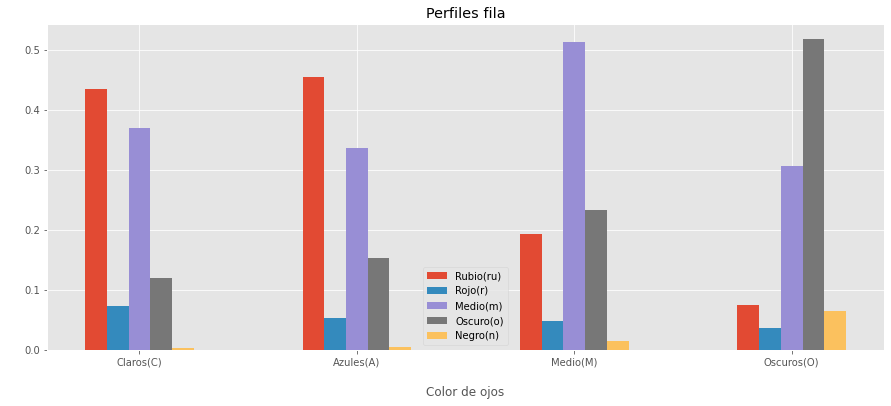

In [16]:
## Plot perfil fila.
temp = pf_row.iloc[0:4,0:5].T
X_axis = np.arange(len(temp.columns))
a = np.flip(np.arange(-0.2,0.3,0.1))
##
for i,index in enumerate(temp.index):
  plt.bar(X_axis -1*a[i], temp.loc[index],width=0.1, label = index)
plt.xticks(X_axis,temp.T.index)
plt.xlabel("\nColor de ojos",)
plt.ylabel(" ",)
plt.title("Perfiles fila")
plt.legend()
plt.show()

La gráfica de arriba, muestra el perfil color de ojos respecto al color del cabello, esto ***muestra una alta similitud entre los perfiles ojos claros y ojos azules***, lo mismo, aunque un poco más baja, ***la similitud o proximidad entre los perfiles ojos medios y oscuros.***

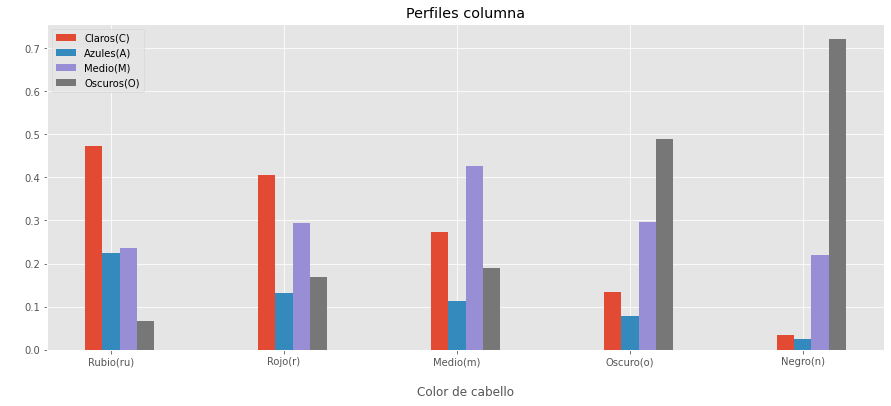

In [17]:
## Plot perfil columna.
plt.figure(figsize=(15,6))
temp = pf_col.iloc[0:5,0:4].T
X_axis = np.arange(len(temp.columns))
a = np.flip(np.arange(-0.2,0.2,0.1))
##
for i,index in enumerate(temp.index):
  plt.bar(X_axis -1*a[i], temp.loc[index],width=0.1, label = index)
plt.xticks(X_axis,temp.T.index)
plt.xlabel("\nColor de cabello",)
plt.ylabel(" ",)
plt.title("Perfiles columna")
plt.legend()
plt.show()

Para el perfil color del cabello (plot anterior), se encuentra una alta ***semejanza entre los perfiles
cabello rubio y rojo***, además de una ***semejanza entre los cabellos oscuro y negro***; el perfil asociado con ***cabello medio*** es bastante diferente de los demás.

## ***Semejanza entre perfiles.***

Una vez que se han definido las dos nubes de puntos, espacio fila $(\mathbb R^{p})$ y espacio columna $(\mathbb R^{n})$, se debe decidir como medir la distancia entre ellos. En el análisis de correspondencias, la semejanza entre dos líneas (o entre dos columnas) está dada por la distancia entre sus perfiles. Esta distancia es conocida con el nombre de distancia _ji-cuadrado_ y se nota por $χ^2$. 

1. La distancia entre dos perfiles fila $i$ y $i'$ esta dada por:

$$d^2(i,i')=∑_{j=1}^p\frac{1}{f_{.j}}\left(\frac{f_{ij}}{f_{i.}}-\frac{f_{i'j}}{f_{i'.}}\right)$$

2. La distancia entre dos perfiles columna $i$ y $i'$ esta dada por:

$$d^2(j,j')=∑_{i=1}^n\frac{1}{f_{i.}}\left(\frac{f_{ij}}{f_{.j}}-\frac{f_{ij'}}{f_{.j'}}\right)$$

Las distancias anteriores comparan los histogramas por cada para de filas o columnas. En esta media se da más "importancia" a las categorías o modalidades con menor frecuencia y menos “importancia” a las que tengan alta frecuencia. Las distancias anteriores se traducen en que el AC da prioridad a las modalidades raras, por cuanto éstas, por su escasez, son más diferenciadoras que las otras.

## ***Ajuste de las dos nubes de puntos.***


El problema consiste en encontrar un subespacio $(\mathbb R^{q})$ de dimensión menor que
el espacio fila $(\mathbb R^{p})$, que conserve el máximo de la información de la nube de puntos original; una medida de la cantidad de información es la
cantidad de varianza o inercia retenida por el subespacio $(\mathbb R^{q})$. De la misma forma que el PCA, el AC procede a buscar una sucesión de ejes ortogonales
sobre los cuales la nube de puntos es proyectada.

De manera completamente análoga se hace para el caso de las columnas.



***Nota:***

1. Cuanto más extremos aparezcan los puntos más seguridad habrá sobre la composición de su perfil.

2. Las relaciones cuasi–baricéntricas permiten la representación simultánea de filas y columnas. Aunque no tiene sentido la distancia entre un punto fila y
un punto columna, pues éstos pertenecen a espacios diferentes, el AC permite ubicar e interpretar un punto de un espacio (fila o columna) con respecto a los
puntos del otro espacio.

## ***Interpretacion de los ejes factoriales.***

El problema central, una vez se ha reducido la dimensionalidad del conjunto de datos, es la asignación de un nombre a los primeros ejes factoriales, para interpretar las proyecciones sobre los planos factoriales, junto con la superposición, de acuerdo con las relaciones de transición.

### 1. ***Contribución absoluta de cada eje a la variabilidad total.***

Esta expresa la proporción de la varianza (inercia) con que una modalidad de la variable contribuye a la varianza "retenida" por el eje. Mediante las contribuciones absolutas se puede saber qué variables son las responsables de la construcción de un factor. Esto muestra la contribución del elemento al eje, permite establecer en cuánta proporción un punto $i$ contribuye a la inercia del eje. Así, para interpretar un eje se deben identificar los puntos de mayor contribución, sin perder de vista que la contribución media de un punto $i$ es $1/n$, separando los puntos de acuerdo con el signo de su coordenada respecto al eje. Una modalidad se considera importante si supera el valor $1/n$, donde $n$ es la cantidad de filas (columnas) de la tabla de contingencias.

### ***2. Contribuciones relativas (cosenos cuadrados) o correlaciones entre elemento-factor.***

Estas expresan las contribuciones de un factor en la "explicación" de la dispersión de un elemento. Las contribuciones relativas muestran cuales son las características exclusivas de este factor. Los cosenos cuadrados permiten medir la calidad de la representación de los puntos en el espacio definido por los primeros ejes factoriales y la detección de puntos mal representados en los ejes seleccionados. ***Valores de estos cosenos al cuadrado próximos a 1*** dan cuenta de puntos que influyen o están asociados altamente con el respectivo eje. Por supuesto, valores bajos indican una contribución “pobre” del eje en la posición del punto. Un valor que se usa para indicar de la importacia es $1/k$ donde $k=min(r,c)-1$.

## ***Retomando el Ejemplo 1.***

In [18]:
## Matriz X para AC.
X = pd.DataFrame(data,columns = ["Rubio(ru)", "Rojo(r)", "Medio(m)","Oscuro(o)", "Negro(n)"],
                 index = ["Claros(C)","Azules(A)", "Medio(M)","Oscuros(O)"])
X.columns.rename("Color Cabello", inplace=True)
X.index.rename("Color Ojos", inplace=True)
X

Color Cabello,Rubio(ru),Rojo(r),Medio(m),Oscuro(o),Negro(n)
Color Ojos,,,,,
Claros(C),688,116,584,188,4
Azules(A),326,38,241,110,3
Medio(M),343,84,909,412,26
Oscuros(O),98,48,403,681,85


In [19]:
## Prueba chi2 de indepencia.
x2_value, p_value, dof, expected = chi2_contingency(X)
print("El p-valor de la prueba de independencia es: {:.3f}".format(p_value))

El p-valor de la prueba de independencia es: 0.000


Este $p$-valor indica que NO hay independencia entre las 2 variables, es decir, hay dependencia estadísticamente significativa entre ambas variables.

In [20]:
## Instanciamos un objeto prince.CA()
ca = prince.CA(n_components=3, random_state=42)
## Ajustamos el CA
ca = ca.fit(X)

El punto en el que el gráfico de sedimentación muestra una curva (llamado "codo") se puede considerar como
indicando una dimensionalidad óptima.

Es importante comentar que se examinan los valores propios (`eigenvalues`) para determinar el número de ejes a considerar. Los valores propios y la proporción de varianzas retenidas por los diferentes ejes se pueden extraer usando el función `get_eigenvalue()`

In [21]:
### Veamos los eigenvalores, varianza y varianza acumulada.
get_eigenvalue(ca)

,eigenvalue,variance_percent,cumulative_variance_percent
Dim1,0.199,86.6,86.6
Dim2,0.030,13.1,99.7
Dim3,0.001,0.4,100.1


La tabla anterior indica que con la primera dimensión se reúne el $86.6\%$ de la varianza y que con la segunda dimensión se reúne casi toda su variabilidad; es
decir, $99.7\%$.

***Nota:*** Los valores propios se pueden utilizar para determinar el número de ejes a retener. No existe una “regla general” para elegir el número de dimensiones a conservar para la interpretación de los datos. Depende de la pregunta de investigación y la necesidad del investigador. Por ejemplo, se puede estar satisfecho con el 80% de la variación total explicada, así que se pueden usar la cantidad de dimensiones necesarias para lograrlo.

### ***Información espacio fila.***

In [22]:
## Contribuciones fila.
contrib = ca.row_contributions()*100
contrib.rename(columns = {0:"Dim1",1:"Dim2",2:"Dim3"})

,Dim1,Dim2,Dim3
Claros(C),28.590673,7.628833,34.450625
Azules(A),10.719176,12.120781,63.831659
Medio(M),0.186754,65.700687,1.181429
Oscuros(O),60.503397,14.549698,0.536287


***Nota:***

+ Las filas que más contribuyen a $Dim1$ y $Dim2$ son las más importantes para explicar la variabilidad en el conjunto de datos.

+ Las filas que no contribuyen mucho a ninguna dimensión o que contribuyen a las últimas dimensiones son
menos importante.

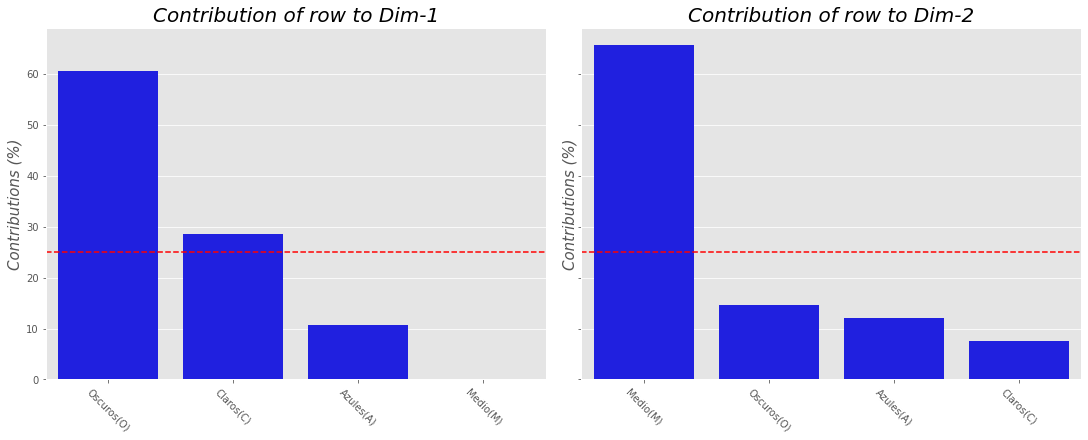

In [23]:
## Plot contribuciones.
plot_contrib(ca,X,choice = "index")

***Comentarios:***

1. Note que en el primer eje los perfiles fila que más contribuyen en su representación son los _colores de ojos_ Oscuros y Claros.

2. Para el segundo eje quien más contribuye es el _color de ojos_ Medio.

3. El _color de ojos_ Azul no contribuye de manera significativa en la construcción de los 2 primeros ejes.

In [24]:
## cos2 fila.
get_cos2(ca,X, choice="index")

,Dim1,Dim2,Dim3
Claros(C),0.956,0.039,0.005
Azules(A),0.836,0.143,0.021
Medio(M),0.018,0.981,0.001
Oscuros(O),0.965,0.035,0.000


Las coordenadas para la “reconstrucción” de la matriz $X$
se obtienen mediante:

In [25]:
## Coordenadas perfiles fila.
ca.F

,0,1,2
Claros(C),-0.440708,-0.088463,-0.031773
Azules(A),-0.400300,-0.165411,0.064158
Medio(M),0.033614,0.245002,0.005553
Oscuros(O),0.702739,-0.133914,-0.004345


In [26]:
plot_cos2(ca,X,choice = "index")

***Comentario:***

Como $cos2$ mide la calidad de la representación de los perfiles fila (en este caso) en los primeros ejes factoriales, tenemos en todos los perfiles una buena representación.

### ***Información espacio columna***

In [27]:
## Contribuciones columna
ca.column_contributions()*100

,0,1,2
Rubio(ru),40.116171,27.130778,4.927568
Rojo(r),1.449827,0.411300,86.089647
Medio(m),0.351615,57.210800,0.483464
Oscuro(o),44.915260,9.273788,3.074599
Negro(n),13.167126,5.973333,5.424723


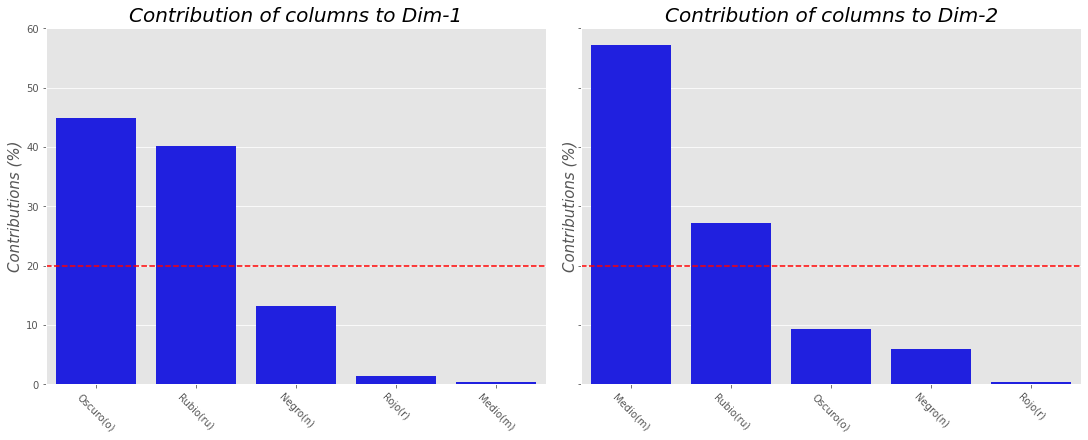

In [28]:
## Contribuciones columna
plot_contrib(ca,X,choice = "columns")

In [29]:
## cos2 perfiles columns
get_cos2(ca,X,choice = "columns")

,Dim1,Dim2,Dim3
Rubio(ru),0.907,0.093,0.000
Rojo(r),0.770,0.033,0.197
Medio(m),0.039,0.961,0.000
Oscuro(o),0.969,0.030,0.000
Negro(n),0.934,0.064,0.002


In [30]:
plot_cos2(ca,X,choice = "columns")

Note que se pueden hacer comentarios similares que en el caso del espacio fila. En particular el _color de cabello_ queda bien presentado en las 2 dimensiones.

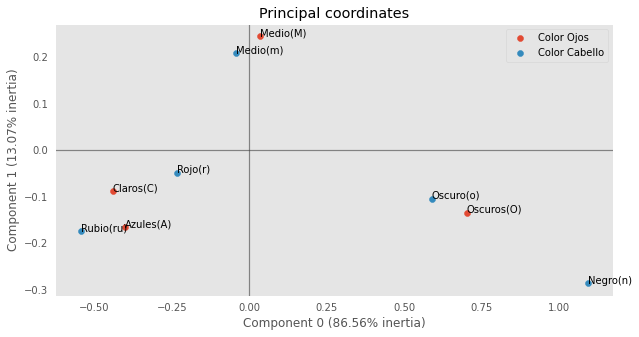

In [31]:
## Biplot libreria prince.
ax = ca.plot_coordinates(X = X,ax = None, figsize=(10,5),x_component=0,
                         y_component=1,show_row_labels=True,show_col_labels=True)

In [32]:
ca_biplot(ca,X)

***Comentarios finales:***

1. La primera dimensión está relacionada con el ***color
del cabello***, variando, de izquierda a derecha, desde el rubio hasta el negro.

2. Se puede apreciar que los datos referentes a los ojos siguen un “patrón” similar al del cabello, con colores oscuros a la derecha y claros a la izquierda. 

3. Los puntos para ***azul***, ***rubio*** están razonablemente próximos.

***En resumen, la dirección del color es de izquierda a derecha, y va de claro a oscuro; tanto para el cabello como para los ojos.***

## ***Ejemplo 2.*** 

Los siguientes datos son una tabla de 1744 registros que contiene 13 tareas domésticas y su reparto en la pareja:

- La primera columna son las diferentes tareas.

- La segunda columna contiene quien realiza dicha tarea: `Wife` (solo la esposa), `Alternating` (alternados), `Husband` (solo el esposo) o `Jointly`.

In [33]:
## Importamos el dataset
url_base = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/"
file_name = "housetasks.csv"
df = pd.read_csv(url_base +file_name)
df.columns = ["task","who"]
for i in df.columns:
  print("-",i,":",df[i].unique(),"\n")

- task : ['Laundry' 'Main_meal' 'Dinner' 'Breakfeast' 'Tidying' 'Dishes' 'Shopping'
 'Official' 'Driving' 'Finances' 'Insurance' 'Repairs' 'Holidays'] 

- who : ['Wife' 'Alternating' 'Husband' 'Jointly'] 



In [34]:
## Tabla de contingencias.
df_crosstab = pd.crosstab(df["task"],df["who"])
df_crosstab

who,Alternating,Husband,Jointly,Wife
task,,,,
Breakfeast,36,15,7,82
Dinner,11,7,13,77
Dishes,24,4,53,32
Driving,51,75,3,10
Finances,13,21,66,13
Holidays,1,6,153,0
Insurance,1,53,77,8
Laundry,14,2,4,156
Main_meal,20,5,4,124


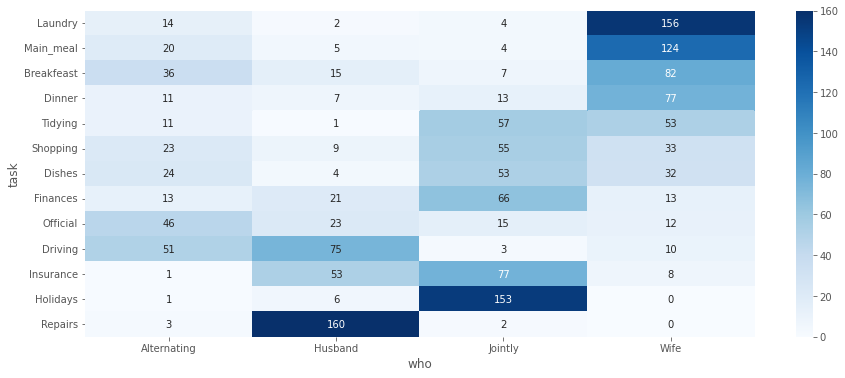

In [35]:
## Heatmap tabla de contingencias.
sns.heatmap(df_crosstab.sort_values(by=["Wife"],ascending=False), annot=True, cmap = "Blues", fmt=".0f")
plt.show()

- Se observa que las tareas de la casa (`Laundry` (lavandería), `Main_Meal` (comida principal) y `Dinner` (cena)) son realizadas con mayor frecuencia por
la esposa.

- `Repairs` (reparaciones) y `Driving` (conducción) son realizadas predominantemente por el esposo.

- Los `Holidays` se asocian con más frecuencia a la columna `Jointly`.


La prueba $\chi^{2}$ de independencia se muestran a continuación:

In [36]:
## Con scipy.
x2_value, p_value, dof, expected = chi2_contingency(df_crosstab)
print("El p-valor de la prueba es:",p_value)

El p-valor de la prueba es: 0.0


Dado el $p$-valor, y a una significancia $\alpha=0.05$ se concluye que:

***LAS TAREAS DEL HOGAR NO SON INDEPENDIENTES DE QUIEN LAS HACE.***

In [37]:
## Creamos y ajustamos un objeto CA de prince.
ca = prince.CA(n_components=3)
ca.fit(df_crosstab)

CA(n_components=3)

In [38]:
## Varianza retenida,
get_eigenvalue(ca)

,eigenvalue,variance_percent,cumulative_variance_percent
Dim1,0.543,48.7,48.7
Dim2,0.445,39.9,88.6
Dim3,0.127,11.4,100.0


+ Recuerde que la dimensión (`Dim1`) explica la mayor cantidad de variación, seguida por la dimensión 2 (`Dim2`) y así sucesivamente. 

+ Alrededor del 88,6% de la variación se explica por las dos primeras dimensiones. Este es un porcentaje aceptablemente alto. 




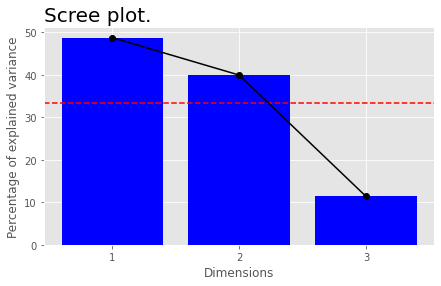

In [39]:
## Gráfico de sedimentación.
screeplot(ca,(7,4))

De acuerdo con el plot anterior, ***solo las dimensiones 1 y 2 deben usarse en la solución***. La dimensión 3
explica sólo el $11,4\%$ de la inercia total y está por debajo de la cantidad:

$$\frac{1}{min(nrow,ncol)-1}=33,33\%$$

que es el valor propio promedio. 

Con un $\%$ tan bajo la dimensión 3, no debería ser considerada en un posterior análisis.

***Nota:*** Tenga en cuenta que puede usar más de 2 dimensiones. Sin embargo, las dimensiones suplementarias no contribuyen significativamente a la interpretación de la naturaleza de la asociación entre las filas y columnas.

In [40]:
## Biplot.
ca_biplot(ca,df_crosstab)

Recuerdemos que la distancia entre cualquier punto de fila o columna da una medida de su similitud (o
disimilitud). Los puntos de fila con un perfil similar se cierran en el mapa de factores. Lo mismo es válido para los puntos de columna.

Este gráfico muestra que:

1. Las tareas del hogar, como la `Dinner`, `Breakfeast`, `laundry` , `Main_meal` son realizadas con mayor frecuencia por la esposa (`Wife`).

2. `Driving` y `Repairs` las realiza el marido (`Husband`).

3. Tareas como `Holidays` y `Finances` se realizan de manera conjunta (`Jointly`).

El siguiente paso para la interpretación es determinar qué perfiles fila y columna contribuyen más
en la definición de las diferentes dimensiones retenidas en el modelo.

### ***Espacio fila***

Recuerde que debemos visualizar los puntos fila en busca de:

1. Sus contribuciones a las dimensiones ***(contribución absoluta)***.
2. Su calidad de representación en el mapa de factores ***(contribución relativa).***

In [41]:
## Coordenadas fila.
ca.F.head()

,0,1,2
Breakfeast,-0.508600,-0.452804,0.220405
Dinner,-0.692574,-0.308104,-0.207414
Dishes,-0.188964,0.441966,0.266949
Driving,0.741770,-0.653414,0.544458
Finances,0.270767,0.617868,0.034797


In [42]:
## Coordenadas de la fila
temp = ca.F
fig = px.scatter(data_frame = temp, x = 0, y = 1, text = temp.index, template = "plotly_white",)
fig.add_hline(y = 0,line_color = "pink")
fig.add_vline(x = 0,line_color = "pink")
fig.show()

***El gráfico anterior muestra las relaciones entre los puntos de fila:***

1. Las filas con un perfil similar se agrupan.

2. Las filas con correlación negativa se colocan en lados opuestos del origen del gráfico (cuadrantes opuestos).

3. La distancia entre los puntos de fila y el origen mide la calidad de los puntos de fila en el mapa del factor. Los puntos de fila que están alejados del origen están bien representados en el mapa de factores.

Algo que es frecuente que suceda es que no todos los puntos se muestran igual "de bien" representados en las dos dimensiones. Recordemos que el $cos2$ mide el grado de asociación entre filas/columnas y un eje en particular, es decir, la calidad de la representación de las filas/columnas  en el mapa de factores.

In [43]:
get_cos2(ca,df_crosstab,choice = "index",)

,Dim1,Dim2,Dim3
Breakfeast,0.505,0.400,0.095
Dinner,0.777,0.154,0.070
Dishes,0.118,0.646,0.236
Driving,0.432,0.335,0.233
Finances,0.161,0.837,0.003
Holidays,0.030,0.962,0.008
Insurance,0.576,0.309,0.115
Laundry,0.740,0.185,0.075
Main_meal,0.742,0.232,0.026
Official,0.053,0.066,0.881


1. ***Los valores de $cos2$ están comprendidos entre 0 y 1. La suma de $cos2$ por filas en todas las dimensiones del CA es igual a uno.***

2. Si un elemento de fila está bien representado por dos dimensiones, la suma de $cos2$ es cercana a 1, para algunos elementos fila, se requieren más de 2 dimensiones para representar perfectamente los datos.

3. La calidad de representación de una fila o columna en $n$ dimensiones es simplemente la suma de las
coseno cuadrado de esa fila o columna sobre las $n$ dimensiones.

Puede visualizar el $cos2$ en los perfiles fila en todas las dimensiones, podemos generar el siguiente mapa de calor.

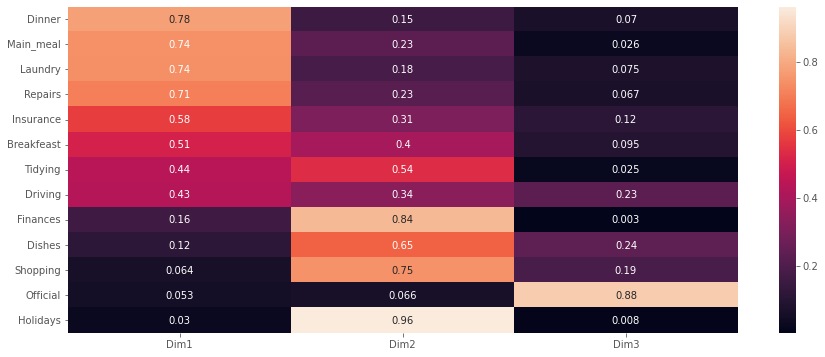

In [44]:
tmp = get_cos2(ca,df_crosstab)[["Dim1","Dim2"]]
sns.heatmap(get_cos2(ca,df_crosstab).sort_values(by=["Dim1"], ascending = False), annot=True)
plt.show()

In [45]:
plot_cos2(ca,df_crosstab,choice = "index")

También podemos generar un barplot de los perfiles filas con el $cos2$ con la función `plot_representation_cos2()`:

In [46]:
plot_bar_cos2(ca,df_crosstab,choice="index")

Notemos que todos los perfiles fila, salvo `Official`, están bien representados por las dos primeras dimensiones. Esto implica que la posición del punto correspondiente al elemento `Official` en el diagrama de dispersión debe ser interpretada con cierta cautela.

La contribución de las filas (en %) a la definición de las dimensiones se extraer de la siguiente manera:

In [47]:
contrib = ca.row_contributions().rename(columns={0:"Dim1",1:"Dim2",2:"Dim3"})*100
contrib.round(2)

,Dim1,Dim2,Dim3
Breakfeast,3.82,3.70,3.07
Dinner,5.47,1.32,2.10
Dishes,0.43,2.84,3.63
Driving,8.08,7.65,18.60
Finances,0.88,5.56,0.06
Holidays,1.08,42.45,1.21
Insurance,6.15,4.02,5.25
Laundry,18.29,5.56,7.97
Main_meal,12.39,4.74,1.86
Official,0.52,0.80,36.94


***Nota:*** Las variables de fila con mayor valor son las que más contribuyen a la definición de las dimensiones.

Es posible crear un heatmap para resaltar la fila que más contribuye en cada dimensión:

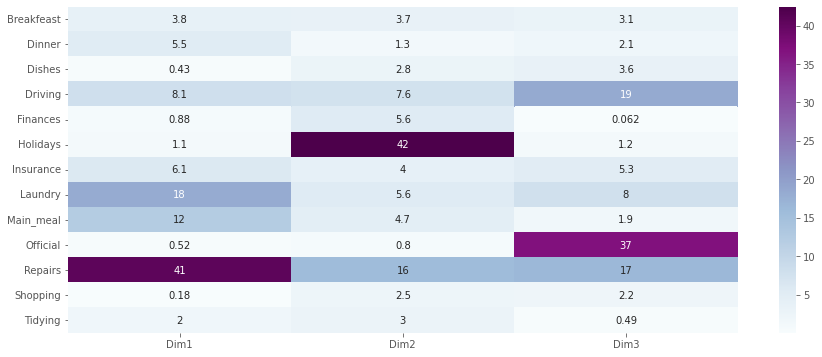

In [48]:
sns.heatmap(contrib, annot = True, cmap = "BuPu")
plt.show()

Podemos también plotear un barplot de las contribuciones de las filas.

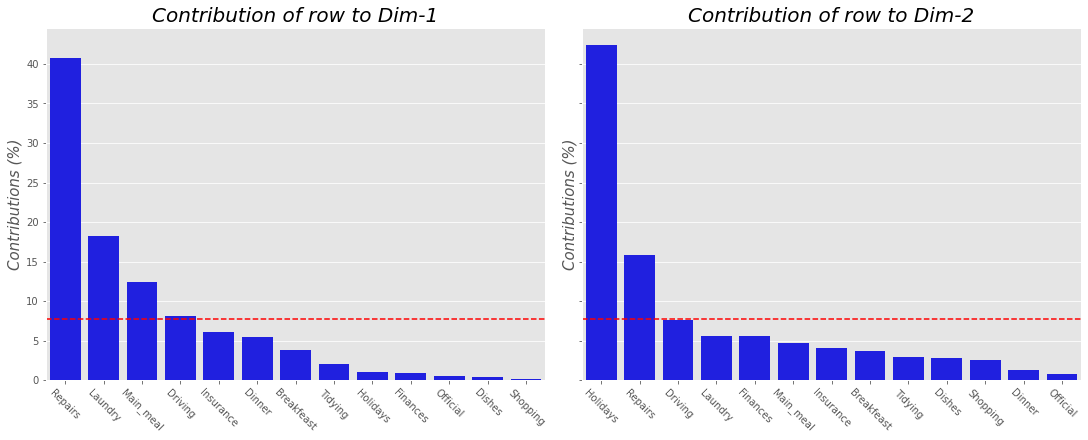

In [49]:
plot_contrib(ca,df_crosstab, choice = "index")

***Nota:***

La línea discontinua roja en el gráfico anterior indica el valor promedio esperado, si las contribuciones fueran uniforme.

Se puede ver que:

1. Los elementos de fila `Repairs`, `Laundry`, `Main_meal` y `Driving` son los más importantes en la definición de la primera dimensión.

2. Los elementos de la fila `Holidays` y `Repairs` son los que más contribuyen a la dimensión 2.

Los puntos de fila más importantes (o contribuyentes) se pueden resaltar en el diagrama de dispersión de la siguiente manera:

In [50]:
tmp = ca.F
contrib = ca.row_contributions()*100
tmp["contrib"] = contrib[[0,1]].mean(axis=1)
px.scatter(data_frame = tmp, x = 0,y = 1, color = "contrib", color_continuous_scale="temps",
           text = tmp.index, template = "plotly_white")

Los perfiles fila `Repairs` y `Driving` tienen una contribución importante en el lado positivo de la primera dimensión, mientras que las categorías `Laundry` y `Main_meal` tienen una mayor contribución al lado negativo de la primera dimensión. En otras palabras, la dimensión 1 se define principalmente por la oposición de `Repairs` y `Driving` (lado postivo), y `Laundry` y `Main_meal` (lado negativo).

### ***Conclusiones espacio fila.***

1. Las variables bien representadas son: `Repairs`, `Driving`, `Holidays`, `Laundry`, `Driving`.

2. La varible que menos es representada es `Official`

### ***Espacio columna.***

In [51]:
plot_bar_cos2(ca,df_crosstab,choice="columns")

In [52]:
## cos2 para las columnas
plot_cos2(ca, df_crosstab, choice = "columns")

Notemos que solo el elemento de la columna `Alternating` no se muestra muy bien en los dos primeros
dimensiones. La posición de este elemento debe interpretarse con cautela en el espacio formado por las
dimensiones 1 y 2.

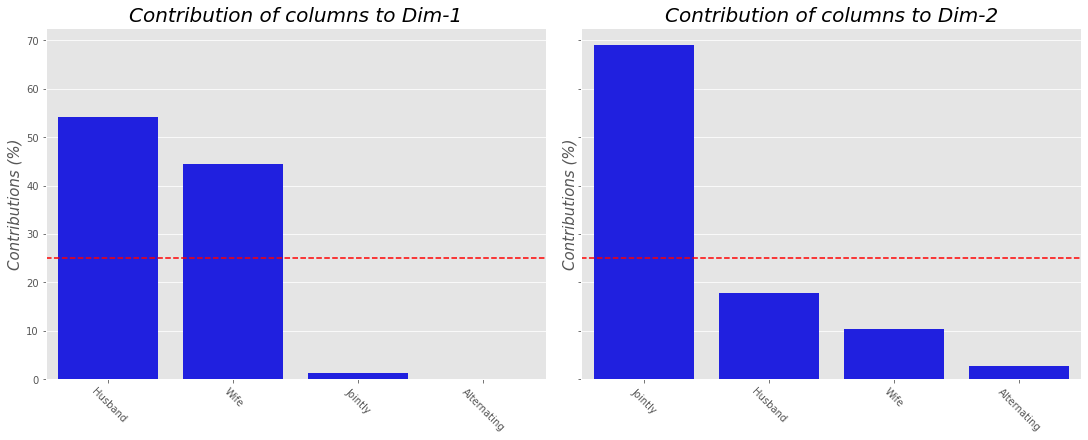

In [53]:
## Contribucion columns
plot_contrib(ca,df_crosstab, choice = "columns")

### ***Conclusiones espacio columna.***

1. Todas están bien representadas salvo `Alternating`.

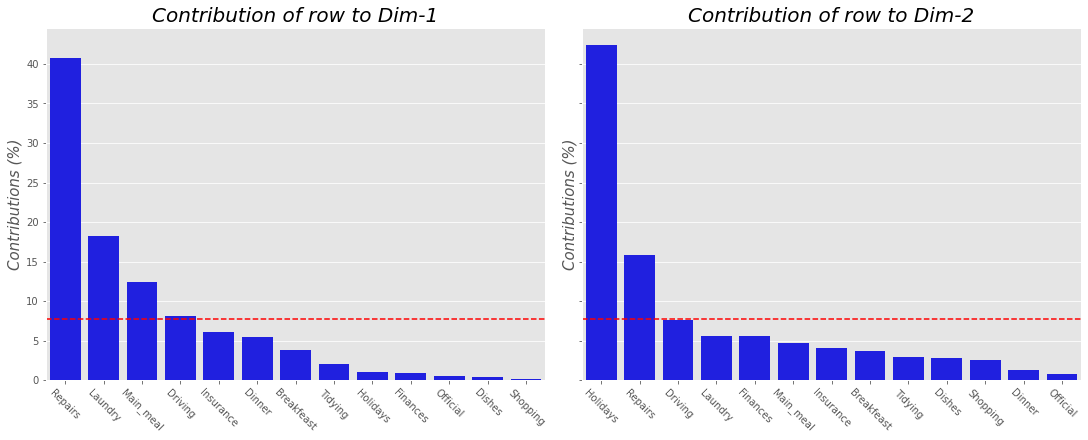

In [54]:
## Contribucion index
plot_contrib(ca,df_crosstab, choice = "index")

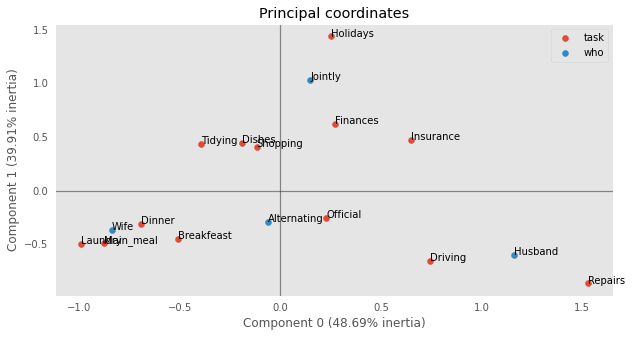

In [55]:
ax = ca.plot_coordinates(X = df_crosstab, ax = None, figsize=(10,5), x_component=0,
                         y_component=1, show_row_labels=True, show_col_labels=True)

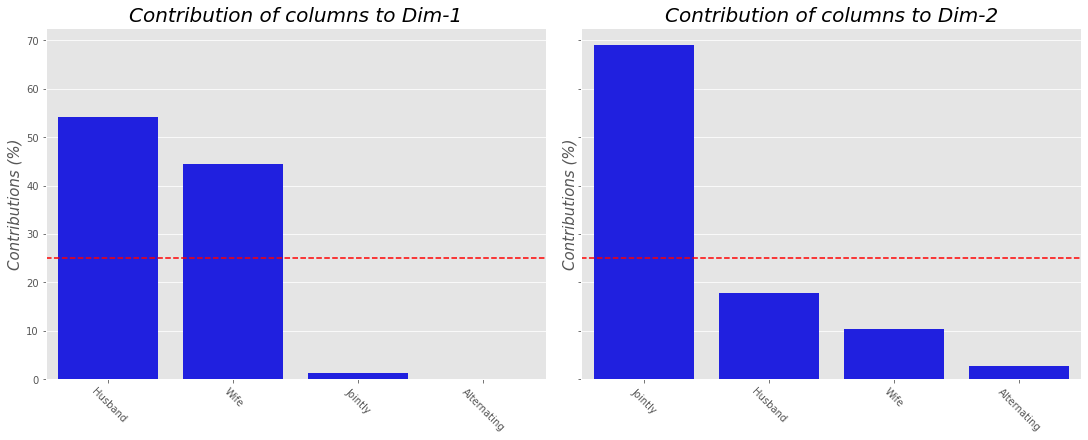

In [56]:
## Contribucion columns
plot_contrib(ca,df_crosstab, choice = "columns")

### ***Conclusiones ejemplo 2.***

1. Las labores del hogar varían según quien las realiza.

2. Dado que `Husband` está bien representado y así mismo `Driving` y `Repairs`. Son precisamente estas últimas labores las "preferidas" por los hombres. A su vez, tiene menor preferencia por `Laundry`.

3. `Alternating` y `Oficial` están mal representados no es posible asumir asociaciones usando esos perfiles.

4. De igual manera, labores como `Main_meal`, `Laundry` están en correspondencia con la esposa. `Repairs` se asocia negativamente con `Wife`.

5. Las labores conjuntas son las vacaciones.


## ***Ejercicio en clase.***

Se pidió a 657 adolescentes que seleccionaran cuál de las 6 características describe mejor 4 marcas populares de teléfonos inteligentes. La data a continuación:

In [57]:
## Data Ejercicio 3.
data = np.array([36,42,7,22,3,5,43,32,56,29,13,35,27,31,24,17,48,36,8,35,37,45,7,19]).reshape(6,4)
row = ["pantalla","precio","diseño","bateria","software","camara"]
cols = ["Apple","Samsung","Nokia","Huawei"]
df = pd.DataFrame(data, index = row, columns = cols )
df.index.rename("caracteristica", inplace=True)
df.columns.rename("marca", inplace=True); df

marca,Apple,Samsung,Nokia,Huawei
caracteristica,,,,
pantalla,36,42,7,22
precio,3,5,43,32
diseño,56,29,13,35
bateria,27,31,24,17
software,48,36,8,35
camara,37,45,7,19


***Realice un análisis de correspondencias con el mayor detalle posible.***

## ***Referencias:***

1. _Análisis estadístico de datos multivariados. Díaz L & Morales M. Publicaciones Facultad de ciencias. UNAL._

2. _Multivariate Analysis II. Kassambara A. Disponible en: http://www.sthda.com/english/_